## pNN HEPMASS-Imbalanced

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from script import utils, cms, hep
from script.utils import free_mem

from script.hep.data import BalancedSequence, UniformSequence
from script.models.layers import Divide
from script.datasets import Hepmass

sns.set()

In [2]:
# for debugging, comment if not needed
%load_ext autoreload
%autoreload 2

In [3]:
utils.set_random_seed(42)

Random seed 42 set.


In [4]:
df = pd.read_csv('data/mcs/signal_bassociated_cat1.csv', dtype=np.float16)
df.sample(10)

,mA,dimuon_deltar,dimuon_deltaphi,dimuon_deltaeta,dimuon_M,dimuon_pt,met_pt,met_phi,met_eta,bjet_n,...,ljet_n,ljet_1_pt,ljet_1_eta,deltar_bjet1_dimuon,deltapt_bjet1_dimuon,deltaeta_bjet1_dimuon,deltaphi_bjet1_dimuon,PU_Weight,weight,type
74687,600.0,2.824219,2.601562,1.096680,609.00,173.125000,12.734375,0.810059,-999.0,1.0,...,2.0,50.125000,-1.426758,2.744141,44.843750,0.556641,2.685547,0.011276,1.0,1.0
326698,600.0,3.162109,3.109375,0.573242,572.00,32.531250,30.562500,3.044922,-999.0,1.0,...,0.0,-1.000000,-10.000000,3.656250,8.632812,2.298828,2.843750,0.963867,1.0,1.0
102277,300.0,2.578125,2.560547,0.307373,275.75,85.000000,41.718750,-1.962891,-999.0,1.0,...,0.0,-1.000000,-10.000000,4.289062,22.984375,3.132812,2.929688,1.000000,1.0,1.0
215141,1000.0,4.144531,3.007812,2.851562,990.50,33.000000,22.656250,1.162109,-999.0,1.0,...,0.0,-1.000000,-10.000000,5.980469,11.265625,5.312500,2.744141,0.878906,1.0,1.0
411360,1000.0,3.140625,3.140625,0.028076,1012.50,25.296875,27.328125,-2.675781,-999.0,1.0,...,0.0,-1.000000,-10.000000,3.234375,45.468750,1.677734,2.765625,0.955566,1.0,1.0
175425,600.0,3.117188,3.000000,0.847168,598.00,101.062500,30.109375,0.270020,-999.0,1.0,...,0.0,-1.000000,-10.000000,3.529297,17.062500,1.925781,2.958984,1.012695,1.0,1.0
276468,400.0,2.972656,2.898438,0.659668,401.75,55.187500,31.796875,1.853516,-999.0,1.0,...,1.0,20.984375,-2.031250,2.890625,19.328125,0.138916,2.886719,0.981445,1.0,1.0
77423,200.0,3.105469,3.011719,0.753418,202.00,74.625000,33.343750,-2.226562,-999.0,1.0,...,1.0,36.812500,-1.230469,3.314453,9.781250,1.090820,3.128906,1.150391,1.0,1.0
460515,500.0,3.083984,3.083984,0.008423,497.75,15.835938,4.949219,1.280273,-999.0,1.0,...,0.0,-1.000000,-10.000000,5.910156,25.625000,5.042969,3.078125,0.878906,1.0,1.0
499279,600.0,3.220703,2.902344,1.396484,588.00,81.875000,4.613281,1.266602,-999.0,1.0,...,0.0,-1.000000,-10.000000,3.511719,26.250000,1.887695,2.960938,0.958008,1.0,1.0


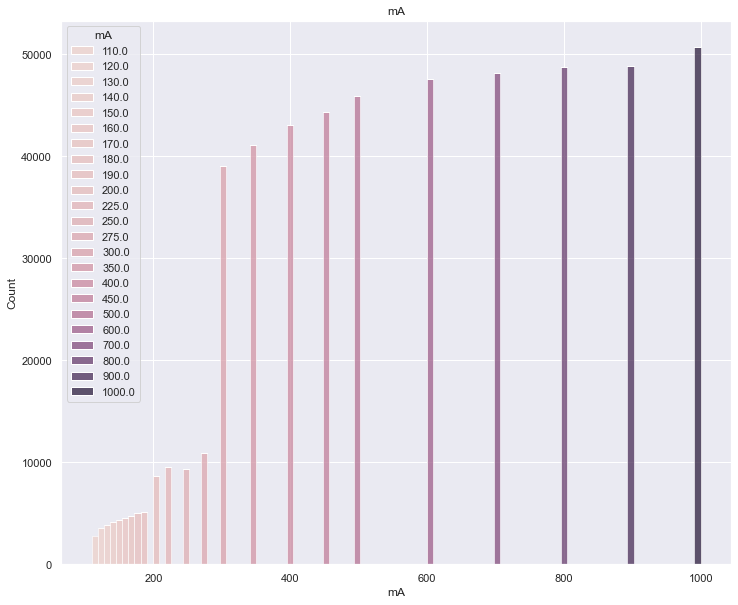

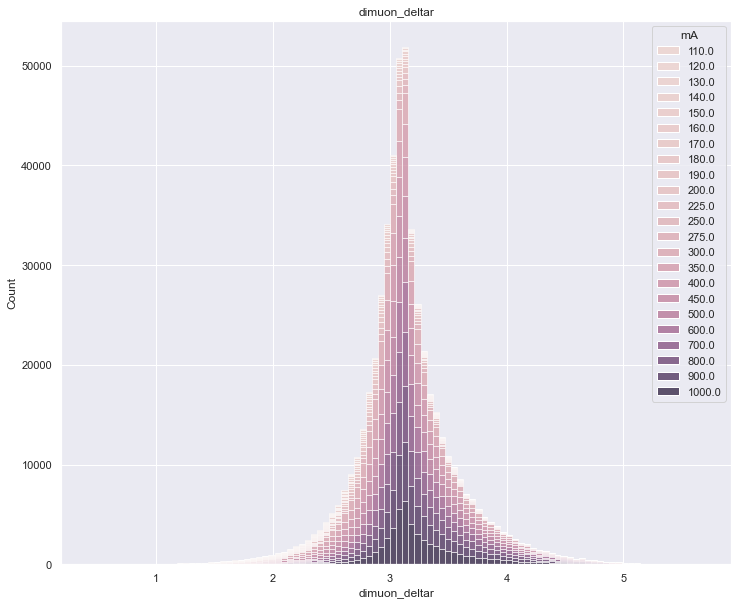

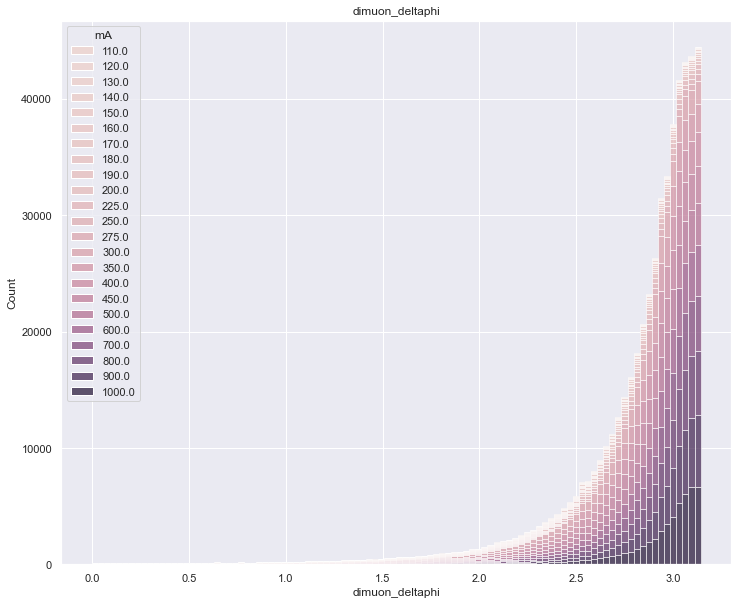

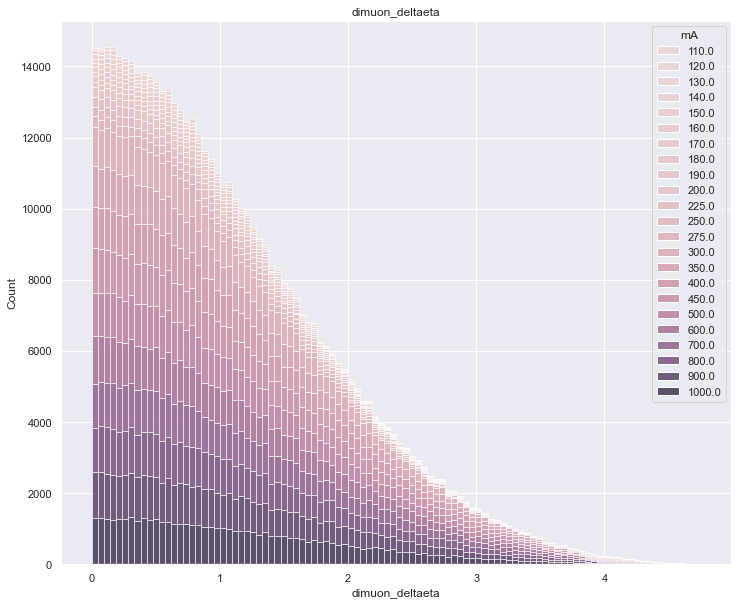

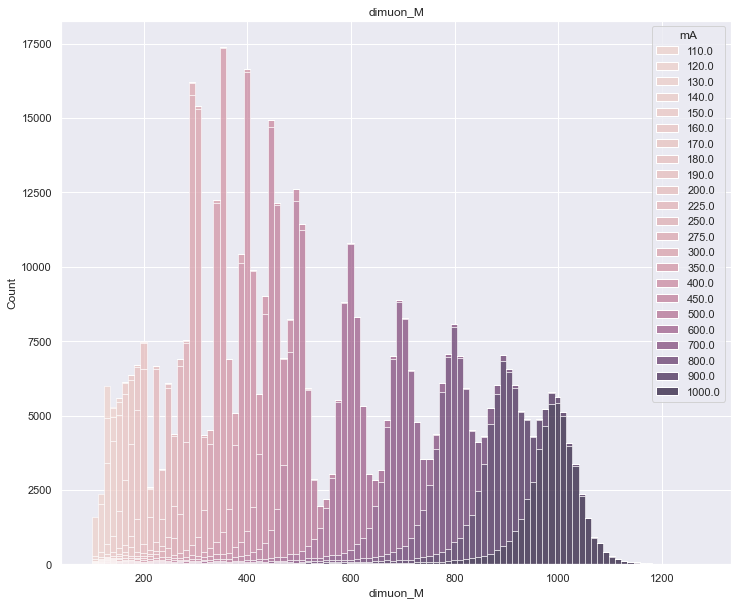

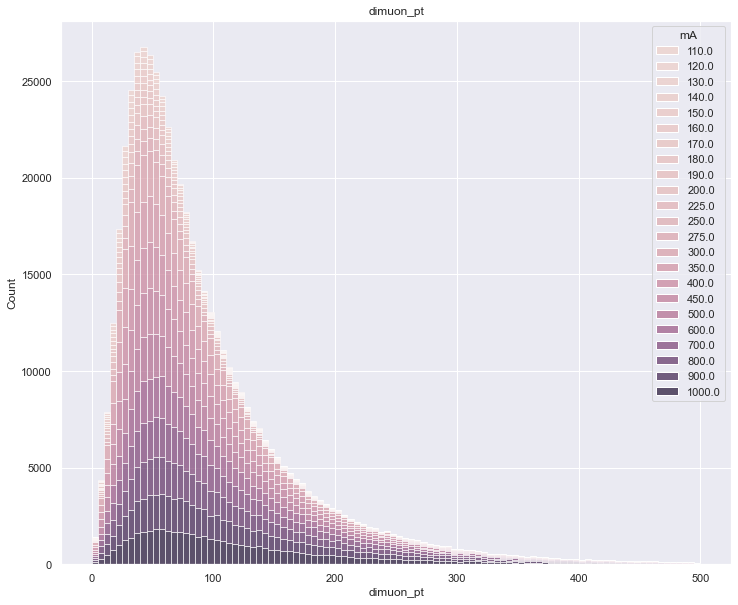

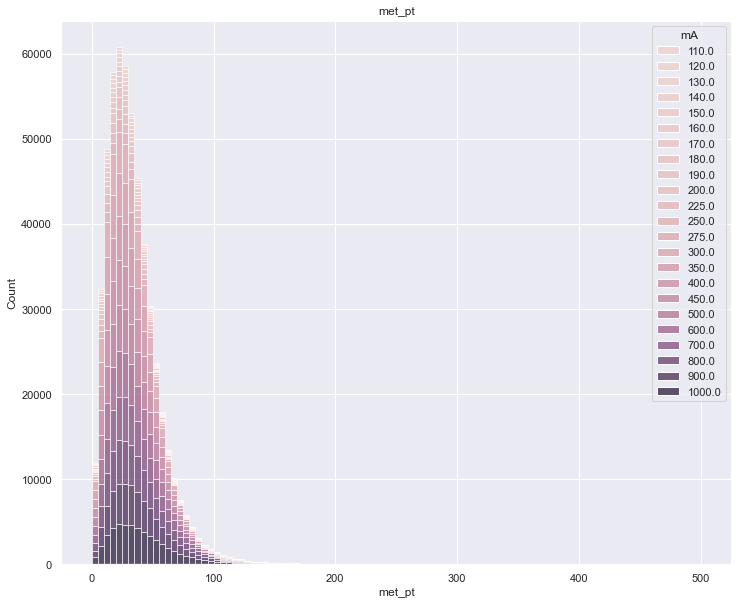

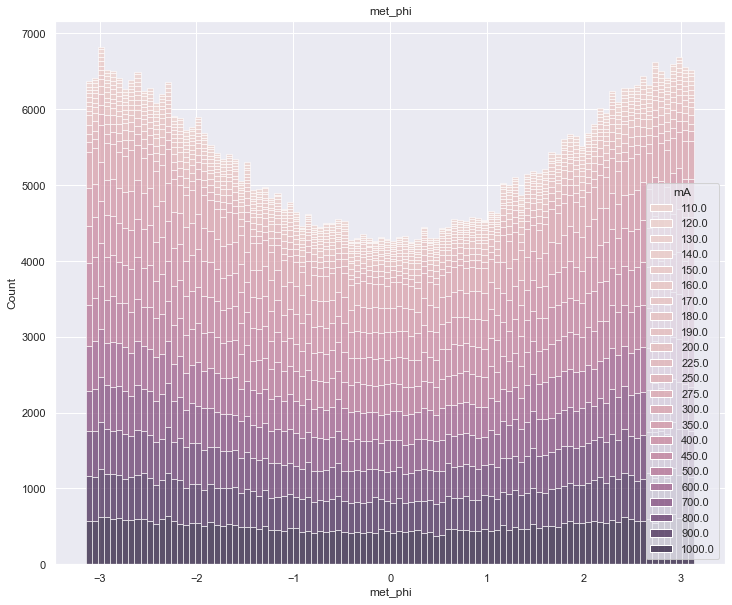

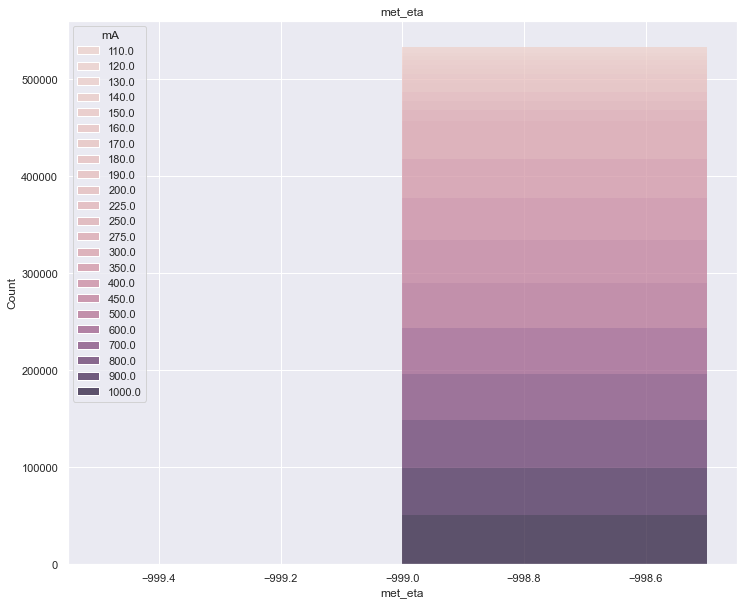

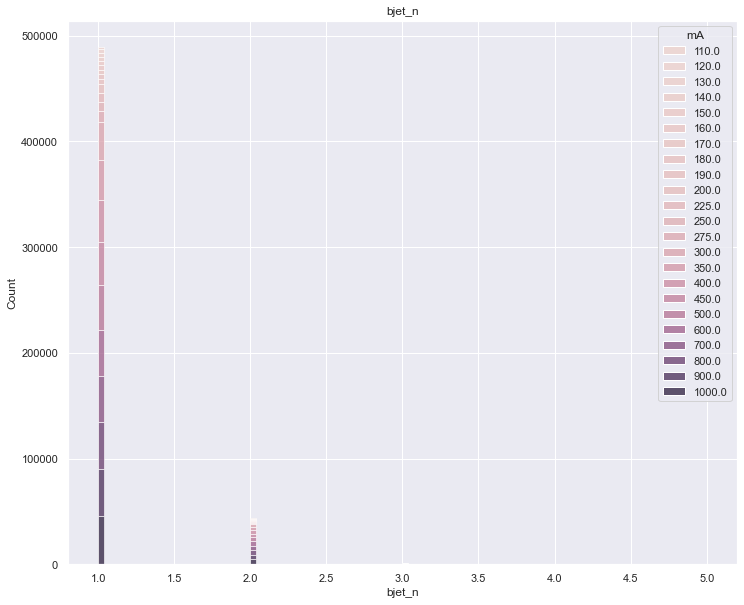

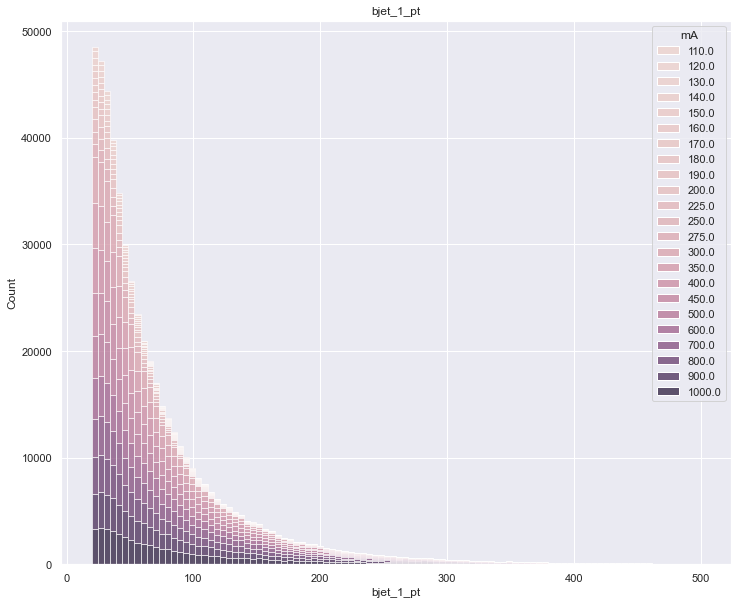

c:\users\luca\appdata\local\programs\python\python38\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


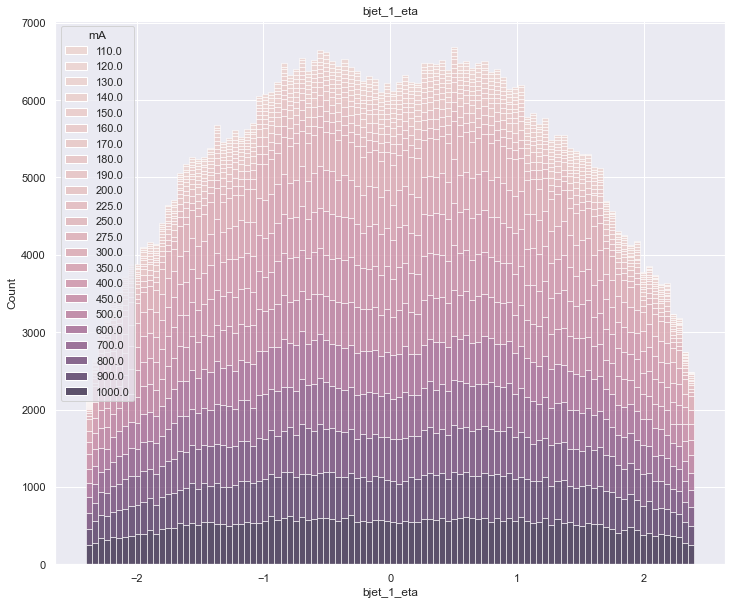

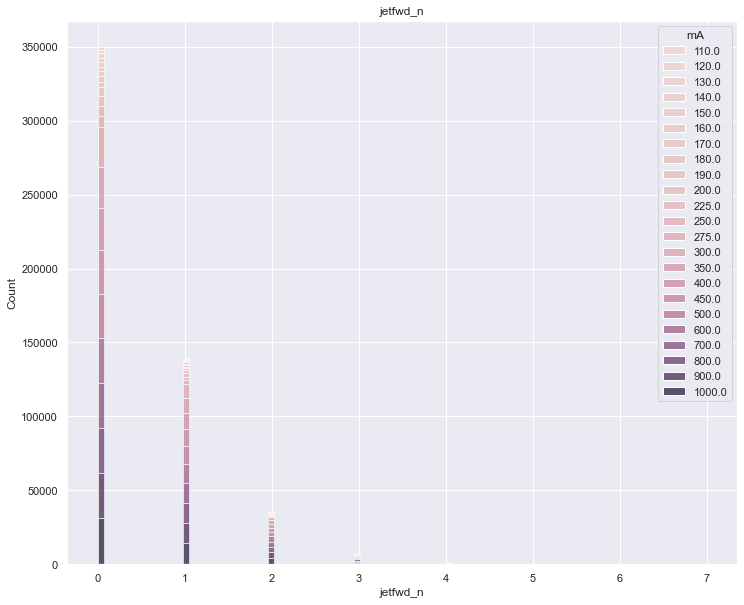

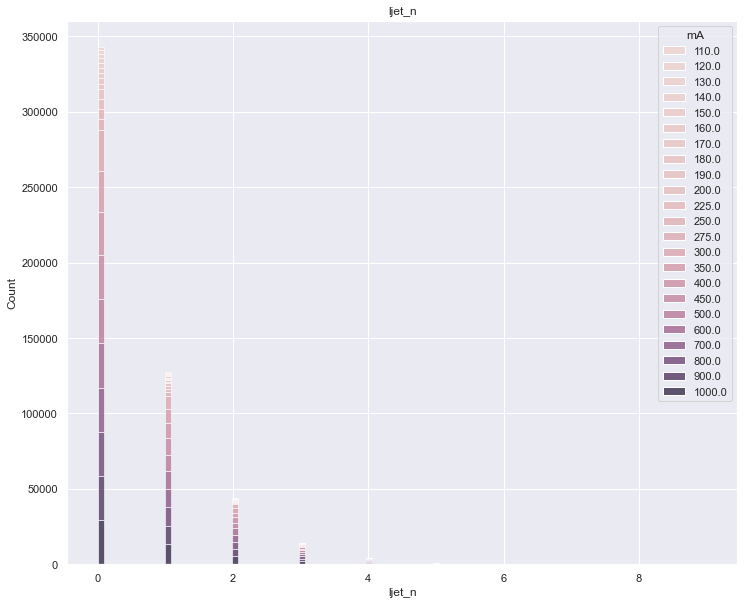

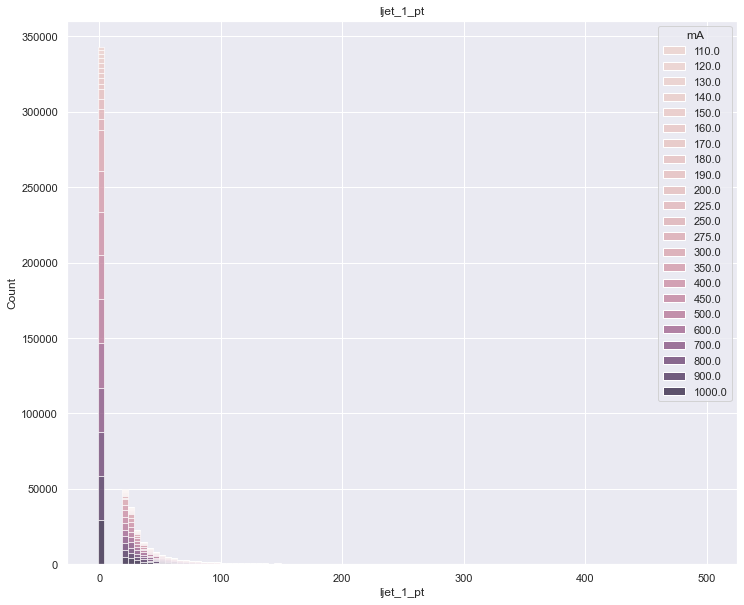

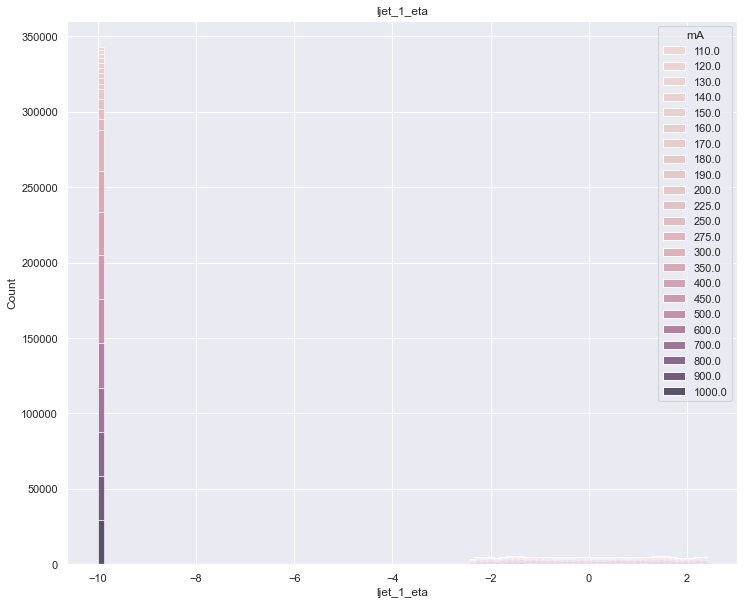

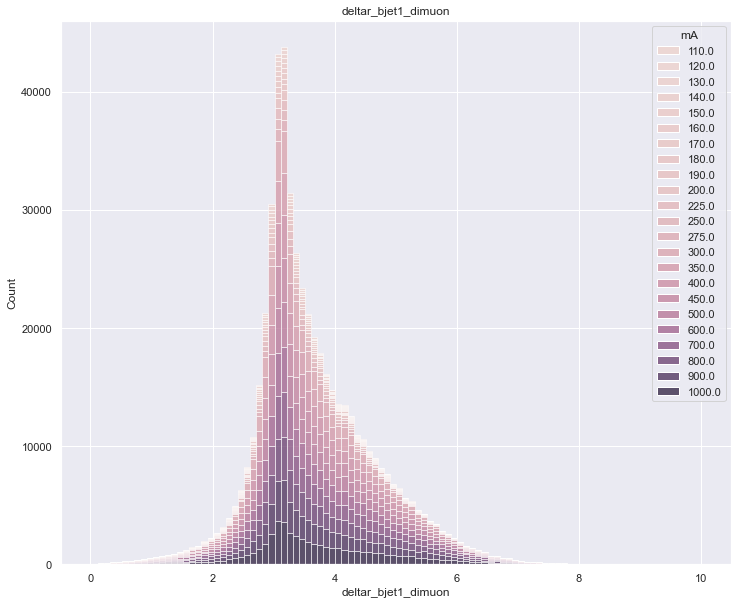

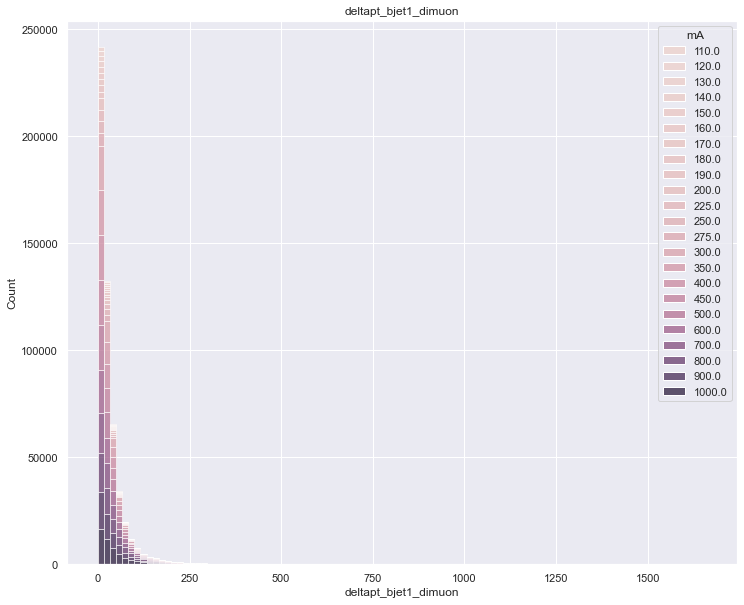

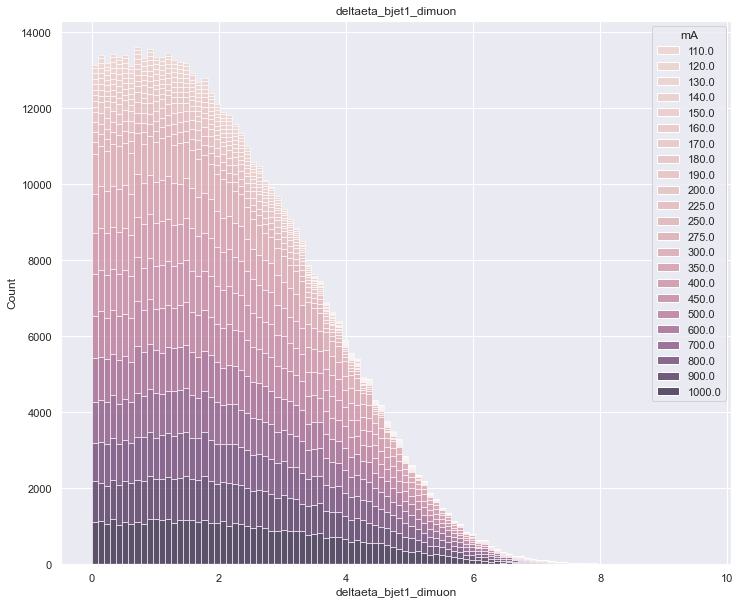

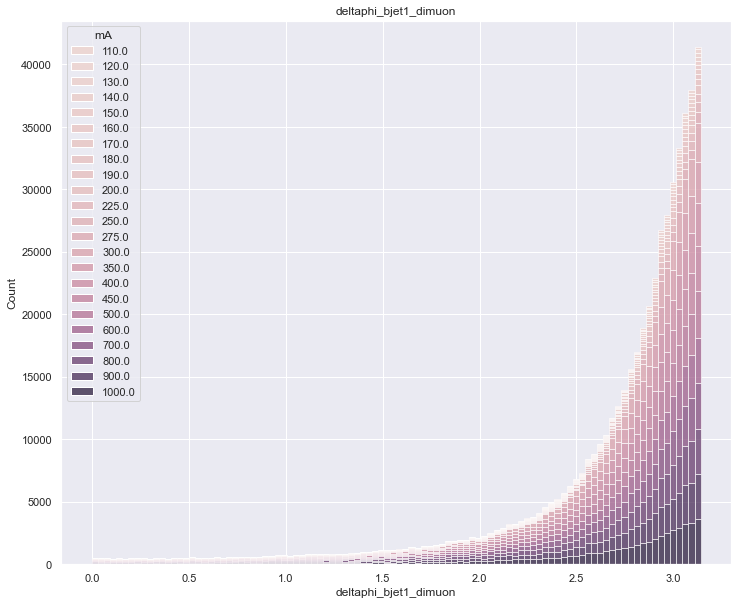

In [21]:
for var in df.columns[:-3]:
    plt.figure(figsize=(12, 10))
    plt.title(var)
    
    x = df[var]
    
    if var == 'dimuon_mass':
        x_range = (100, 1200)
    
    elif '_pt' in var:
        x_range = (x.min(), 500)
    else:
        x_range = None
    
    # x.plot(kind='hist', bins=100, range=x_range)
    sns.histplot(df, x=var, hue='mA', bins=100, binrange=x_range, multiple='stack')
    
    plt.plot()
    free_mem()

In [26]:
df = pd.read_csv('data/mcs/background_cat1.csv', dtype=None)
df.sample(10)

,mA,dimuon_deltar,dimuon_deltaphi,dimuon_deltaeta,dimuon_M,dimuon_pt,met_pt,met_phi,met_eta,bjet_n,...,ljet_1_pt,ljet_1_eta,deltar_bjet1_dimuon,deltapt_bjet1_dimuon,deltaeta_bjet1_dimuon,deltaphi_bjet1_dimuon,PU_Weight,weight,bkg_name,type
525203,676.16350,3.165454,2.985089,1.053253,225.33140,33.284157,40.757526,0.774414,-999.0,1,...,81.06250,-1.259033,1.449225,121.340840,1.438075,0.179421,1.008561,2.777789e-06,TTbar,0
505007,181.47273,3.078477,1.623273,2.615723,242.67506,94.555115,11.364451,-3.049805,-999.0,1,...,30.28125,0.623291,3.190323,58.523860,1.313301,2.907473,0.927296,2.777789e-06,TTbar,0
50037,224.77095,2.483411,1.365723,2.074158,152.43306,86.692350,207.745400,0.288025,-999.0,1,...,150.37500,-0.789673,2.016124,57.067356,0.611685,1.921093,1.080885,9.793903e-09,diboson_ZZTo2L2Nu,0
766738,116.39740,2.927649,1.903503,2.224365,139.66610,53.424260,105.635475,2.967773,-999.0,1,...,66.56250,-0.135651,2.613753,41.950740,0.320955,2.593972,1.026654,2.777789e-06,TTbar,0
455924,941.77870,3.471923,2.786987,2.070496,188.55170,24.884565,110.189354,-2.596191,-999.0,1,...,203.62500,-0.567383,1.803342,123.365430,1.799795,0.113047,1.086071,2.777789e-06,TTbar,0
222748,434.36847,2.864056,2.863953,0.024375,165.91030,45.165524,83.361830,1.713135,-999.0,2,...,-1.00000,-10.000000,2.421945,17.084476,0.900365,2.248369,0.963098,2.777789e-06,TTbar,0
758884,811.58750,2.245069,2.148926,0.649963,182.85945,115.744300,96.204800,3.092285,-999.0,1,...,135.25000,0.016777,1.218334,64.681800,1.094734,0.534692,0.996116,2.777789e-06,TTbar,0
326934,547.28630,3.220893,2.853302,1.494263,107.75797,29.272942,75.843080,1.192871,-999.0,1,...,77.62500,-1.677734,2.734154,23.883308,2.530455,1.035566,1.070661,2.777789e-06,TTbar,0
50758,141.68057,0.762792,0.328918,0.688232,107.67852,569.258240,279.912350,1.299560,-999.0,2,...,48.53125,0.790283,2.655718,61.758240,0.111485,2.653377,1.102669,9.793903e-09,diboson_ZZTo2L2Nu,0
620585,426.86523,3.431215,2.779785,2.011475,139.94098,38.263794,69.221940,-0.356628,-999.0,1,...,48.90625,1.312988,3.846919,25.861206,2.283956,3.095534,1.071548,2.777789e-06,TTbar,0


In [28]:
df.columns

Index(['mA', 'dimuon_deltar', 'dimuon_deltaphi', 'dimuon_deltaeta', 'dimuon_M',
       'dimuon_pt', 'met_pt', 'met_phi', 'met_eta', 'bjet_n', 'bjet_1_pt',
       'bjet_1_eta', 'jetfwd_n', 'ljet_n', 'ljet_1_pt', 'ljet_1_eta',
       'deltar_bjet1_dimuon', 'deltapt_bjet1_dimuon', 'deltaeta_bjet1_dimuon',
       'deltaphi_bjet1_dimuon', 'PU_Weight', 'weight', 'bkg_name', 'type'],
      dtype='object')

In [29]:
df.shape

(814694, 24)

---
### Imbalanced Data
Manually imbalance the dataset, such that: `#signal` decreases as mA increases, `#bkg` increases as mA increases, instead.

In [4]:
# load training data
data = Hepmass()
data.load(path=Hepmass.TRAIN_PATH)

loading...
dataset loaded.


#### Building the Imbalanced Dataset

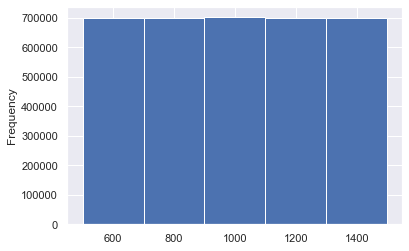

In [7]:
data.signal['mass'].plot(kind='hist', bins=5)

In [10]:
counts = data.signal['mass'].value_counts()
counts

1000.0    701440
1250.0    700418
750.0     700156
1500.0    699500
500.0     699365
Name: mass, dtype: int64

In [5]:
# build imbalanced signal
alpha = 0.6
signal = []

for i, mass in enumerate(data.unique_signal_mass):
    s = data.signal[data.signal['mass'] == mass]
    
    if i == 0:
        signal.append(s)  # take all signal
    else:
        amount = len(s) * alpha
        alpha *= alpha
        
        signal.append(s.sample(n=int(amount), random_state=utils.SEED))

# imbalanced signal
signal = pd.concat(signal)
free_mem()

signal['mass'].value_counts()

500.0     699365
750.0     420093
1000.0    252518
1250.0     90774
1500.0     11748
Name: mass, dtype: int64

In [6]:
# build imbalanced background
beta = 0.6 
bkg = []

for i, mass in enumerate(reversed(data.unique_signal_mass)):
    b = data.background[data.background['mass'] == mass]
    
    if i == 0:
        bkg.append(b)  # take all
    else:
        amount = len(b) * beta
        beta *= beta
        
        bkg.append(b.sample(n=int(amount), random_state=utils.SEED))

# imbalanced background
bkg = pd.concat(bkg)
free_mem()

bkg['mass'].value_counts()

1500.0    700146
1250.0    419680
1000.0    252171
750.0      90821
500.0      11727
Name: mass, dtype: int64

In [7]:
# write to disk
df = pd.concat([signal, bkg])
df.to_csv('data/hepmass/imbalanced-60.csv', index=False)

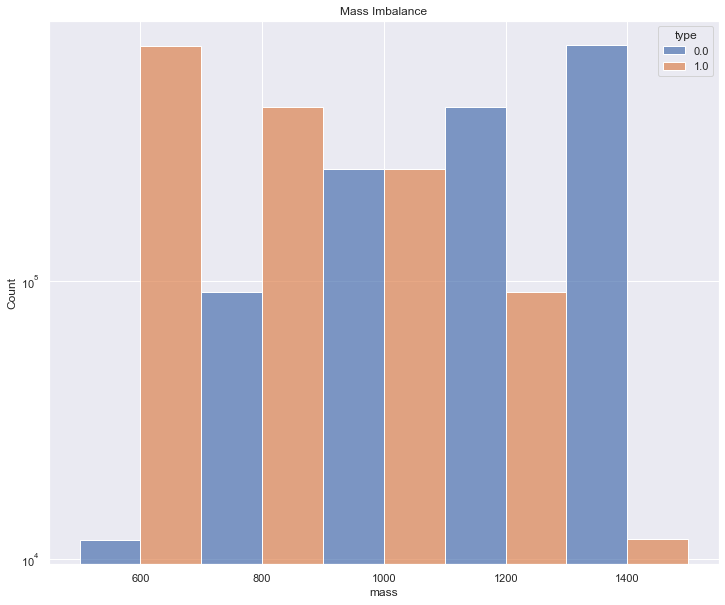

In [23]:
plt.figure(figsize=(12, 10))
plt.title('Mass Imbalance')

sns.histplot(data.ds, hue='type', x='mass', bins=5, multiple='dodge', alpha=0.7)

plt.yscale('log')

---

In [4]:
# load training data
data = Hepmass()
data.load(path='data/hepmass/imbalanced-60.csv')

loading...
dataset loaded.


In [5]:
# preprocessing layers
preproc = {'m': [Divide(1000.0)]}

### Training

In [69]:
l2_kernel = tf.keras.regularizers.l2(1e-3)
l2_bias = tf.keras.regularizers.l2(1e-4)

model, checkpoint = utils.get_compiled_pnn(data, save='hepmass/imbalanced-pnn',
                                           kernel_regularizer=l2_kernel,
                                           bias_regularizer=l2_bias,
                                           monitor='val_ams', lr=3e-4,
                                           dropout=0.5, preprocess=preproc)

In [18]:
train, valid = data.to_dataset(batch_size=1024, validation_split=0.5)

In [71]:
model.fit(x=train, epochs=25, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/25
1440/1440 - 37s - loss: 4.8150 - binary_accuracy: 0.9742 - auc: 0.3031 - precision: 0.9997 - recall: 0.9745 - ams: 0.9999 - class-loss: 0.4922 - fool-loss: 0.0000e+00 - lr: 3.0000e-05 - grad-norm: 0.2962 - weight-norm: 20.1272 - adversarial-loss: 0.0000e+00 - reg-losses: 0.4032 - val_loss: 11.4695 - val_binary_accuracy: 2.4550e-04 - val_auc: 0.5000 - val_precision: 2.4550e-04 - val_recall: 1.0000 - val_ams: 0.0157
Epoch 2/25
1440/1440 - 36s - loss: 5.0286 - binary_accuracy: 0.9996 - auc: 0.4760 - precision: 0.9997 - recall: 0.9999 - ams: 0.9999 - class-loss: 0.2994 - fool-loss: 0.0000e+00 - lr: 3.0000e-05 - grad-norm: 0.0525 - weight-norm: 17.0449 - adversarial-loss: 0.0000e+00 - reg-losses: 0.2891 - val_loss: 12.3216 - val_binary_accuracy: 2.4754e-04 - val_auc: 0.5000 - val_precision: 2.4754e-04 - val_recall: 1.0000 - val_ams: 0.0157
Epoch 3/25
1440/1440 - 34s - loss: 5.0186 - binary_accuracy: 0.9997 - auc: 0.4675 - precision: 0.9997 - recall: 1.0000 - ams: 0.9999 - class-l

KeyboardInterrupt: 

In [ ]:
utils.load_from_checkpoint(model, path='hepmass/imbalanced-pnn')

#### Affine

In [19]:
l2_kernel = tf.keras.regularizers.l2(1e-4)
l2_bias = tf.keras.regularizers.l2(1e-5)

affine, checkpoint = utils.get_compiled_affine(data, bias_regularizer=l2_bias,
                                               kernel_regularizer=l2_kernel, lr=3e-4,
                                               save='hepmass/imbalanced-affine',
                                               preprocess=preproc, dropout=0.5)

In [20]:
affine.fit(x=train, epochs=25, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/25
1440/1440 - 42s - loss: 8.4565 - binary_accuracy: 0.9995 - auc: 0.4152 - precision: 0.9997 - recall: 0.9998 - ams: 0.9999 - fool-loss: 0.0000e+00 - class-loss: 0.0664 - lr: 3.0000e-04 - grad-norm: 0.0959 - weight-norm: 12.8844 - reg-losses: 0.0117 - adversarial-loss: 0.0000e+00 - val_loss: 15.0105 - val_binary_accuracy: 2.5975e-04 - val_auc: 0.5040 - val_precision: 2.5975e-04 - val_recall: 1.0000 - val_ams: 0.0162
Epoch 2/25
1440/1440 - 38s - loss: 10.6249 - binary_accuracy: 0.9997 - auc: 0.4315 - precision: 0.9997 - recall: 1.0000 - ams: 0.9999 - fool-loss: 0.0000e+00 - class-loss: 0.0227 - lr: 3.0000e-04 - grad-norm: 0.0353 - weight-norm: 10.2462 - reg-losses: 0.0035 - adversarial-loss: 0.0000e+00 - val_loss: 20.0776 - val_binary_accuracy: 2.4008e-04 - val_auc: 0.5000 - val_precision: 2.4008e-04 - val_recall: 1.0000 - val_ams: 0.0155
Epoch 3/25
1440/1440 - 38s - loss: 10.3029 - binary_accuracy: 0.9997 - auc: 0.4450 - precision: 0.9997 - recall: 1.0000 - ams: 0.9999 - fool-

In [21]:
utils.load_from_checkpoint(affine_bal, path='hepmass/imbalanced-affine')

Loaded from "weights\hepmass/imbalanced-affine\weights-01-0.504"


### Balanced Training + mA Sampling

In [6]:
train, valid = BalancedSequence.get_data(data, train_batch=1024)

In [21]:
l2_kernel = tf.keras.regularizers.l2(1e-5)
l2_bias = tf.keras.regularizers.l2(1e-6)

balanced, checkpoint = utils.get_compiled_pnn(data, save='hepmass/imbalanced-pnn-balanced',
                                              kernel_regularizer=l2_kernel,
                                              bias_regularizer=l2_bias,
                                              preprocess=preproc, dropout=0.25)

In [32]:
balanced.fit(x=train, epochs=25, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/25
2168/2168 - 55s - loss: 0.2767 - binary_accuracy: 0.8564 - auc: 0.9390 - precision: 0.8416 - recall: 0.8781 - ams: 0.8630 - class-loss: 0.3152 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1873 - weight-norm: 20.4846 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0042 - val_loss: 0.1350 - val_binary_accuracy: 0.9492 - val_auc: 0.9825 - val_precision: 0.8634 - val_recall: 0.8225 - val_ams: 0.8844
Epoch 2/25
2168/2168 - 50s - loss: 0.2997 - binary_accuracy: 0.8707 - auc: 0.9489 - precision: 0.8540 - recall: 0.8943 - ams: 0.8764 - class-loss: 0.2887 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1983 - weight-norm: 20.3475 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0040 - val_loss: 0.1463 - val_binary_accuracy: 0.9453 - val_auc: 0.9795 - val_precision: 0.8424 - val_recall: 0.8225 - val_ams: 0.8700
Epoch 3/25
2168/2168 - 49s - loss: 0.2846 - binary_accuracy: 0.8742 - auc: 0.9512 - precision: 0.8573 - recall: 0.8978 - ams: 0.8795 - class-loss: 0.2824 - fool-loss: 0

In [22]:
utils.load_from_checkpoint(balanced, path='hepmass/imbalanced-pnn-balanced')

Loaded from "weights\hepmass/imbalanced-pnn-balanced\weights-23-0.985"


#### Affine

In [7]:
l2_kernel = tf.keras.regularizers.l2(1e-5)
l2_bias = tf.keras.regularizers.l2(1e-6)

affine_bal2, checkpoint = utils.get_compiled_affine(data, lr=3e-4,
                                                    bias_regularizer=l2_bias,
                                                    kernel_regularizer=l2_kernel,
                                                    save='hepmass/imbalanced-affine-balanced-l2',
                                                    preprocess=preproc, dropout=0.25)

In [8]:
affine_bal2.fit(x=train, epochs=25, validation_data=valid, verbose=2, callbacks=[checkpoint])

Epoch 1/25
2168/2168 - 63s - loss: 0.3114 - binary_accuracy: 0.8222 - auc: 0.9188 - precision: 0.8082 - recall: 0.8449 - ams: 0.8422 - fool-loss: 0.0000e+00 - class-loss: 0.3570 - lr: 3.0000e-04 - grad-norm: 0.0976 - weight-norm: 21.4310 - reg-losses: 0.0042 - adversarial-loss: 0.0000e+00 - val_loss: 0.1633 - val_binary_accuracy: 0.9434 - val_auc: 0.9739 - val_precision: 0.8246 - val_recall: 0.8343 - val_ams: 0.8554
Epoch 2/25
2168/2168 - 61s - loss: 0.3074 - binary_accuracy: 0.8592 - auc: 0.9426 - precision: 0.8347 - recall: 0.8959 - ams: 0.8682 - fool-loss: 0.0000e+00 - class-loss: 0.3040 - lr: 3.0000e-04 - grad-norm: 0.1252 - weight-norm: 21.5902 - reg-losses: 0.0041 - adversarial-loss: 0.0000e+00 - val_loss: 0.1521 - val_binary_accuracy: 0.9531 - val_auc: 0.9762 - val_precision: 0.8418 - val_recall: 0.8817 - val_ams: 0.8726
Epoch 3/25
2168/2168 - 59s - loss: 0.2761 - binary_accuracy: 0.8630 - auc: 0.9453 - precision: 0.8396 - recall: 0.8975 - ams: 0.8708 - fool-loss: 0.0000e+00 - c

In [9]:
utils.load_from_checkpoint(affine_bal2, path='hepmass/imbalanced-affine-balanced-l2')

Loaded from "weights\hepmass/imbalanced-affine-balanced-l2\weights-23-0.985"


### Evaluation + Comparison

In [10]:
# load test-set
test = Hepmass()
test.load(path=Hepmass.TEST_PATH)

loading...
dataset loaded.


In [11]:
model = utils.get_compiled_pnn(test, preprocess=preproc, dropout=0.25)
utils.load_from_checkpoint(model, path='hepmass/imbalanced-pnn')

balanced = utils.get_compiled_pnn(test, preprocess=preproc, dropout=0.25)
utils.load_from_checkpoint(balanced, path='hepmass/imbalanced-pnn-balanced')

Loaded from "weights\hepmass/imbalanced-pnn\weights-01-0.016"
Loaded from "weights\hepmass/imbalanced-pnn-balanced\weights-23-0.985"


In [11]:
models = {'pNN': model, 'balanced': balanced} 

In [12]:
affine = utils.get_compiled_affine(test, preprocess=preproc, dropout=0.25)
utils.load_from_checkpoint(affine, path='hepmass/imbalanced-affine')

affine_bal = utils.get_compiled_affine(test, preprocess=preproc, dropout=0.25)
utils.load_from_checkpoint(affine_bal, path='hepmass/imbalanced-affine-balanced-l2')

Loaded from "weights\hepmass/imbalanced-affine\weights-01-0.504"
Loaded from "weights\hepmass/imbalanced-affine-balanced-l2\weights-23-0.985"


In [10]:
models = {'pNN': model, 'affine': affine, 'balanced': balanced, 'affine-bal': affine_bal} 

Significance:

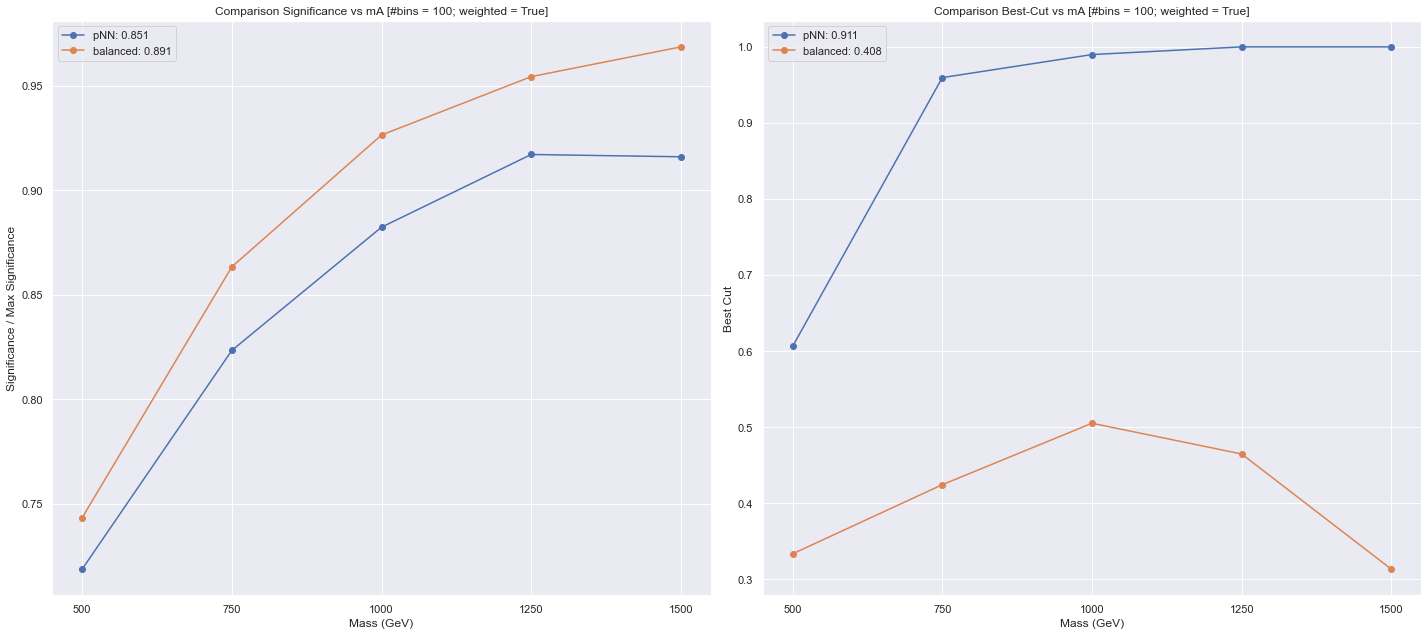

In [12]:
hep.significance_vs_mass(models, dataset=test, bins=100)

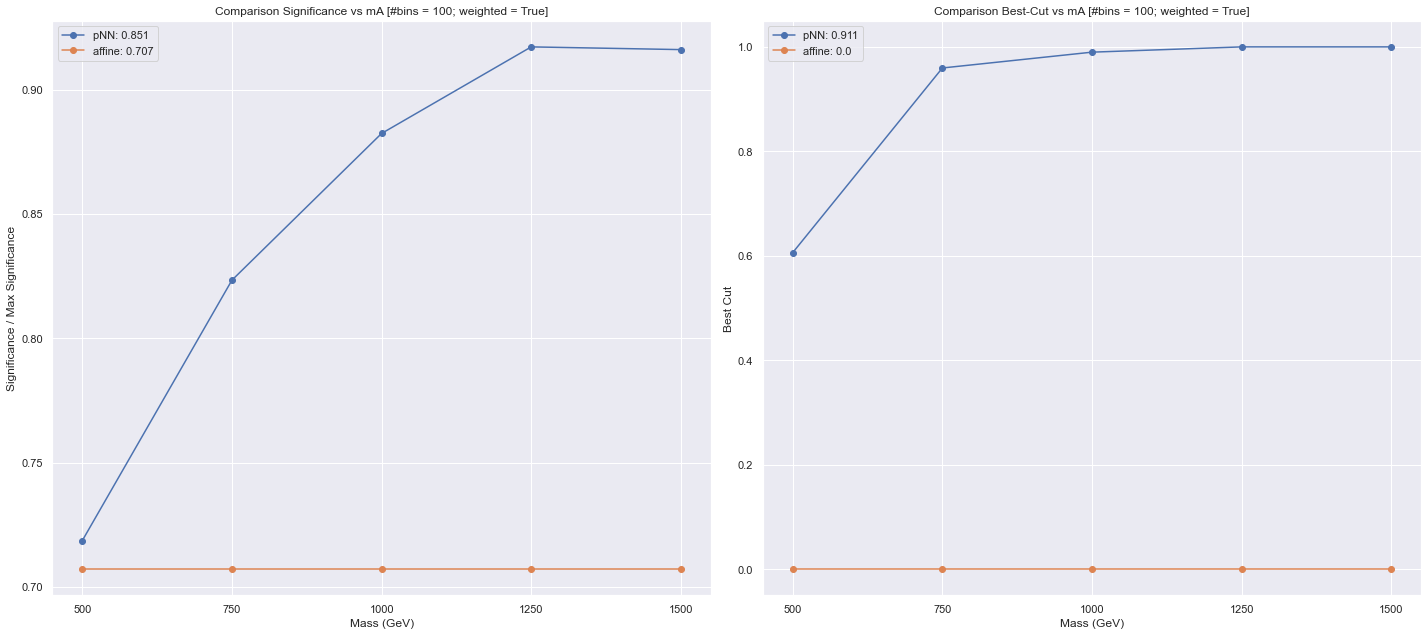

In [ ]:
hep.significance_vs_mass({'pNN': model, 'affine': affine}, dataset=test, bins=100)

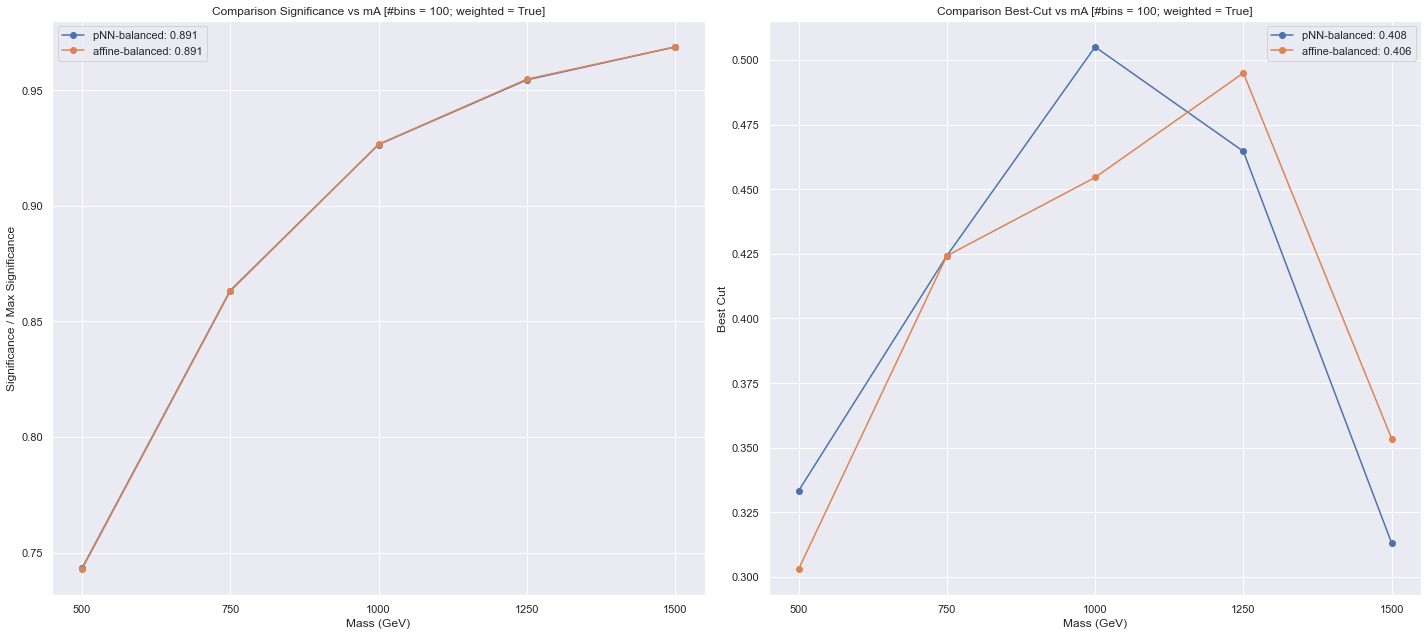

In [17]:
hep.significance_vs_mass({'pNN-balanced': balanced, 'affine-balanced': affine_bal}, 
                         dataset=test, bins=100)

In [15]:
free_mem()

21027

=== 500 mA ===


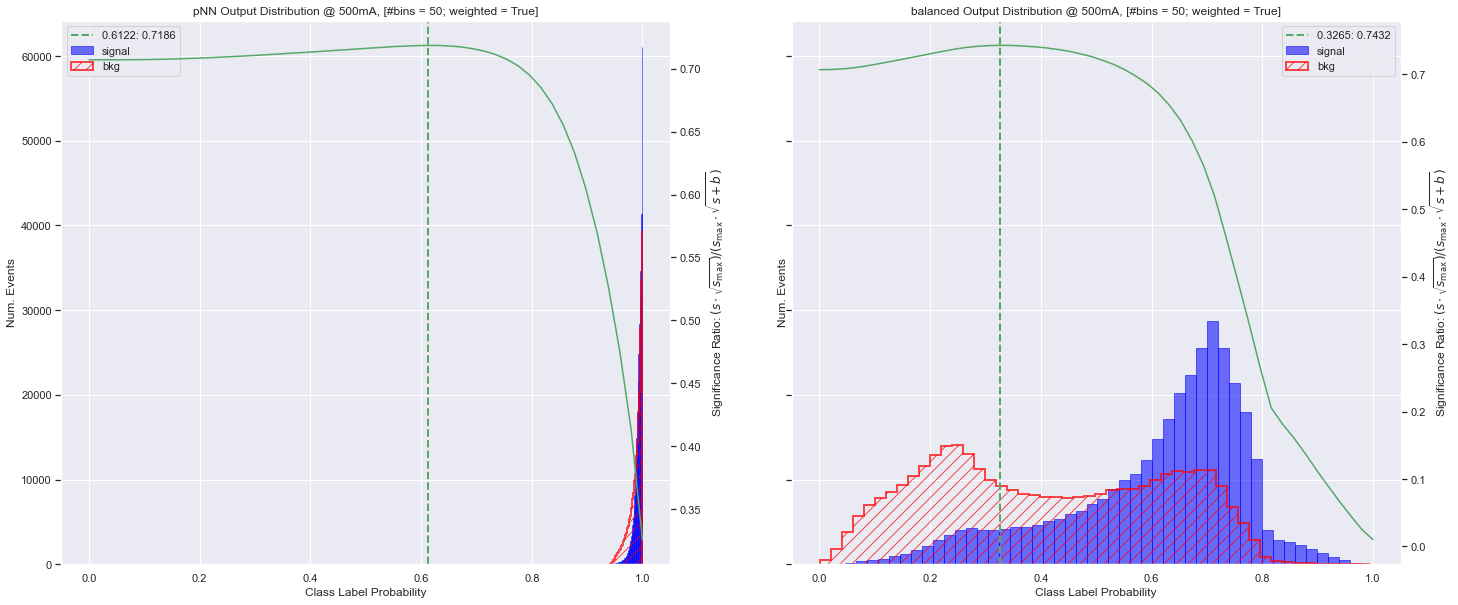

=== 750 mA ===


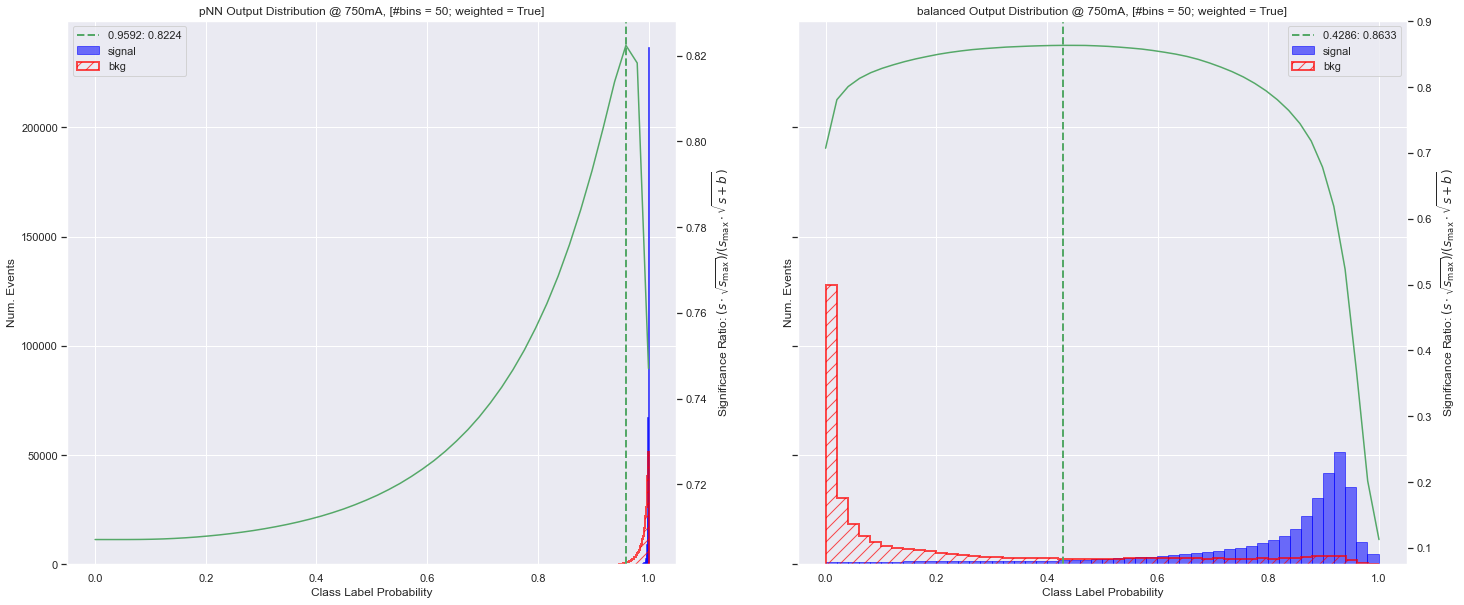

=== 1000 mA ===


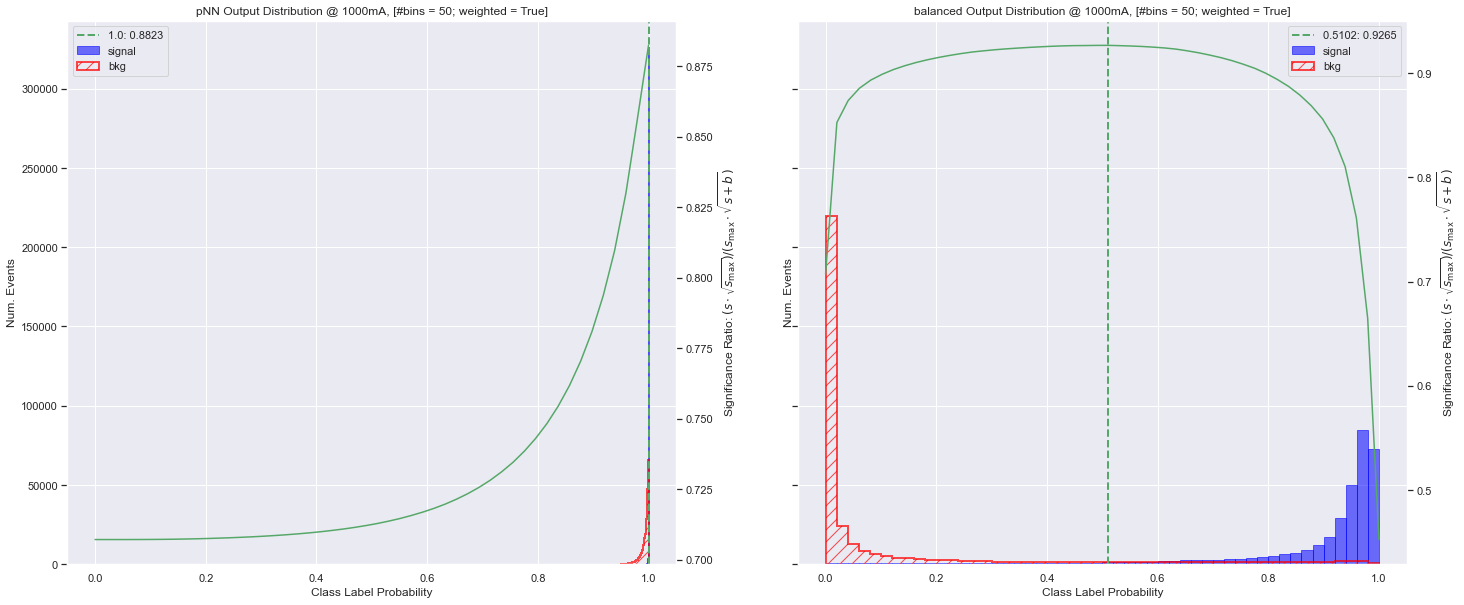

=== 1250 mA ===


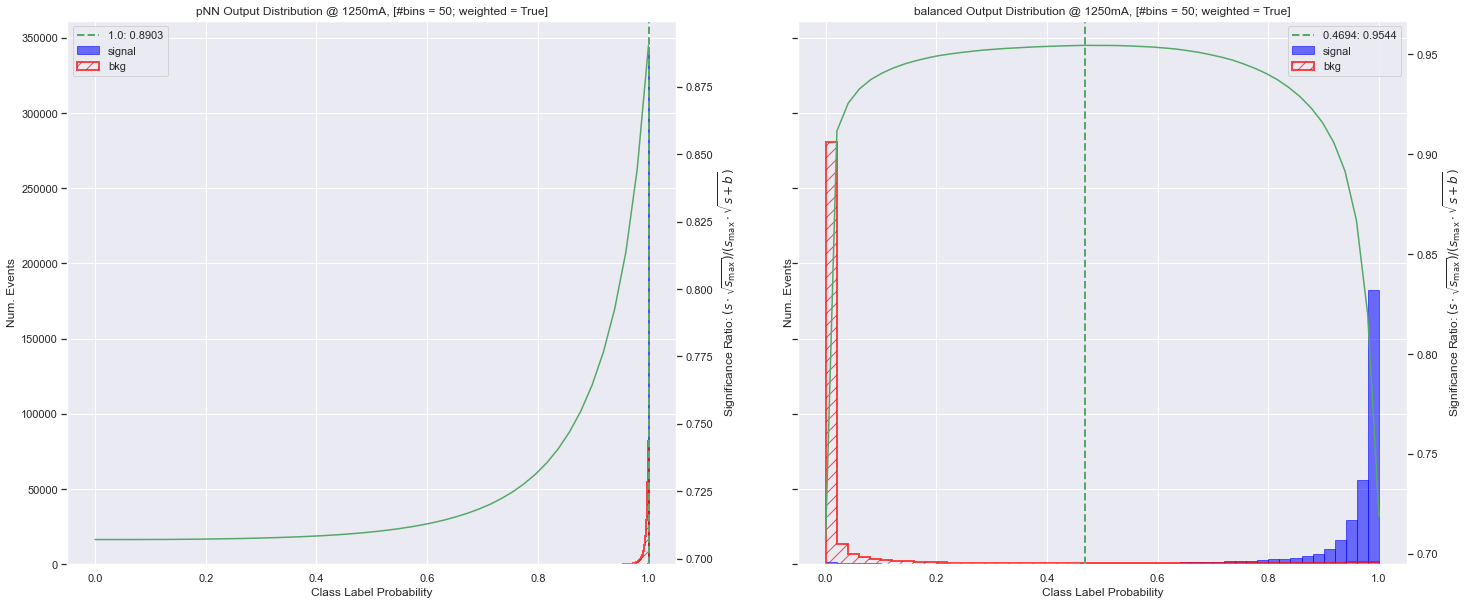

=== 1500 mA ===


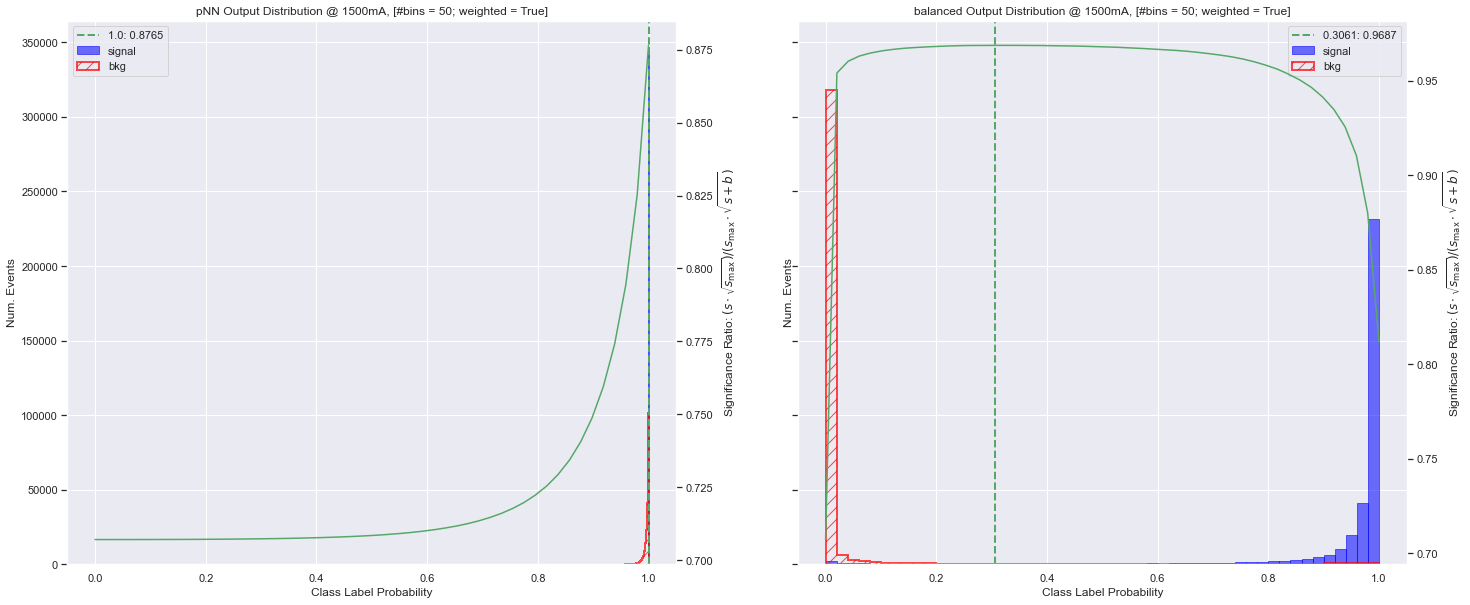

In [14]:
for mass in test.unique_signal_mass:
    print(f'=== {int(mass)} mA ===')
    axes = utils.get_plot_axes(rows=1, cols=2, sharey=True)
    
    for ax, (name, pnn) in zip(axes, models.items()):
        hep.plot.significance(pnn, test, mass=mass, bins=50, ax=ax, name=name, 
                              show=False, ratio=True)
    plt.show()
    free_mem()

=== 500 mA ===


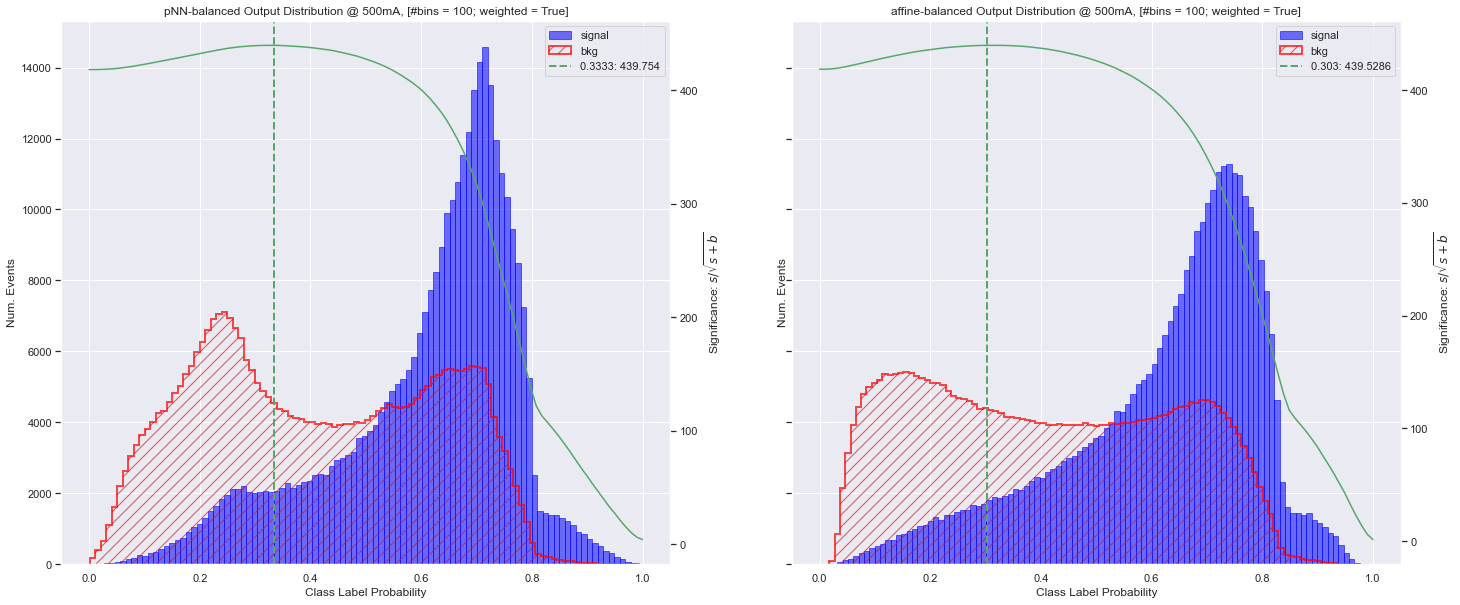

=== 750 mA ===


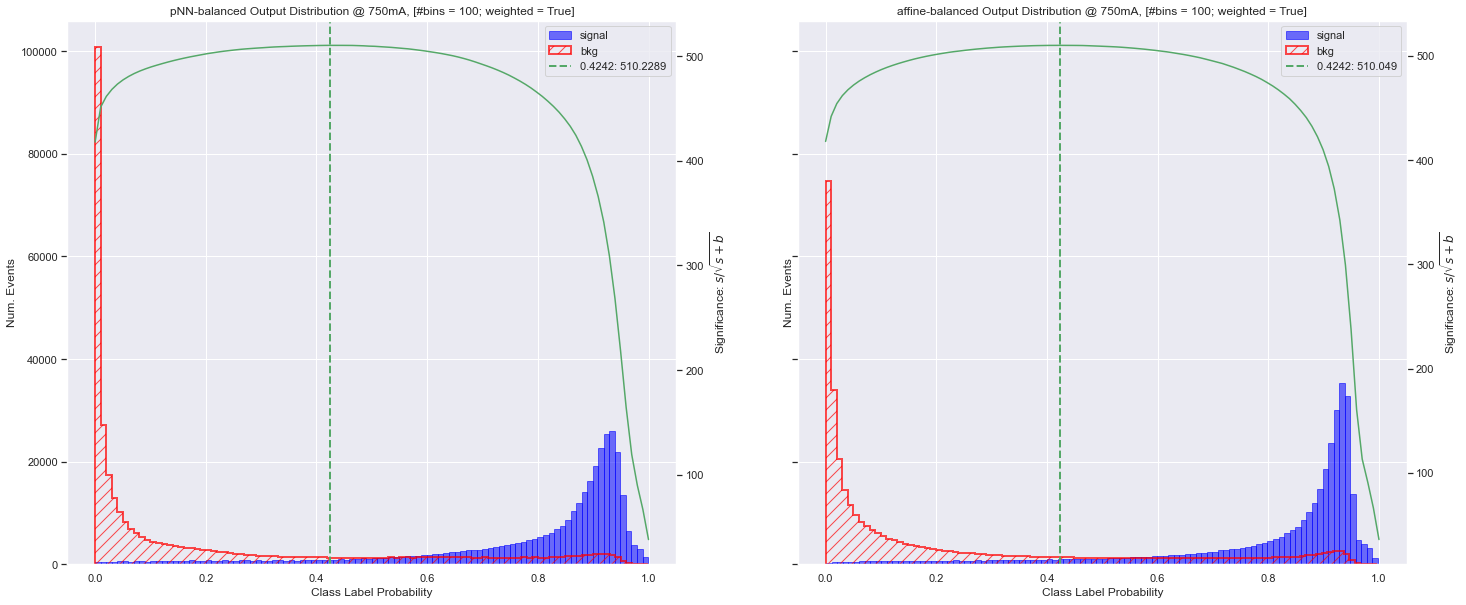

=== 1000 mA ===


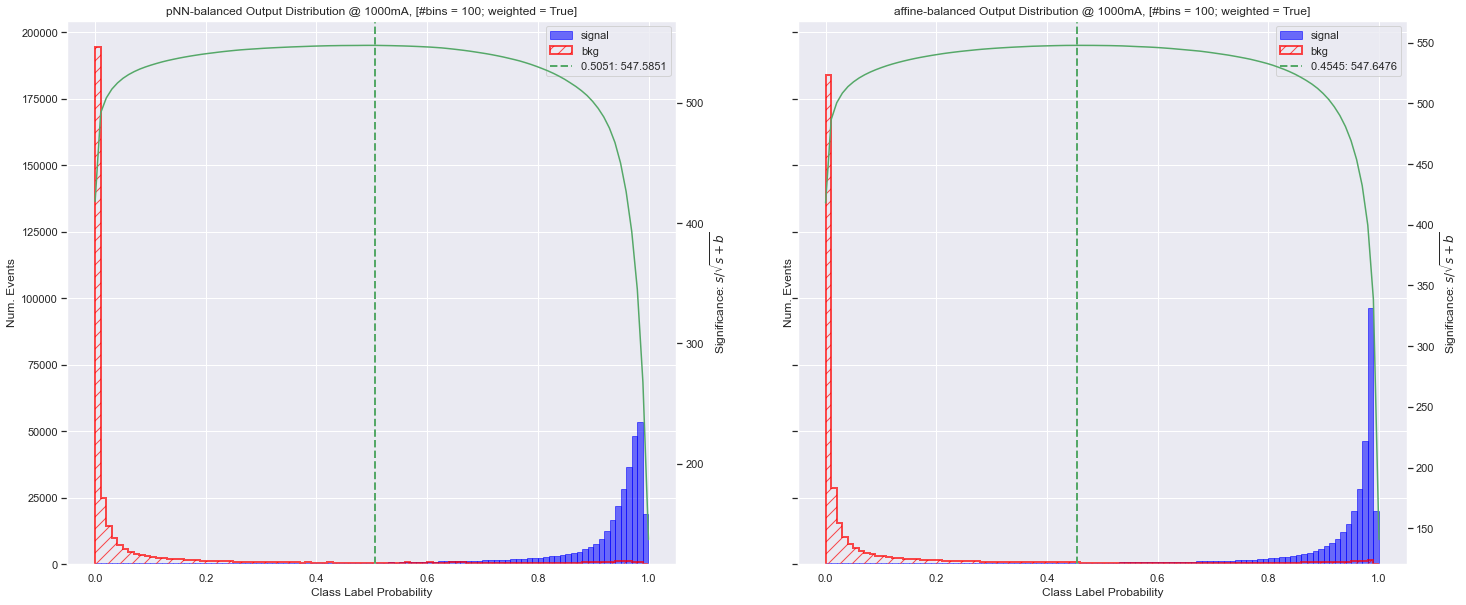

=== 1250 mA ===


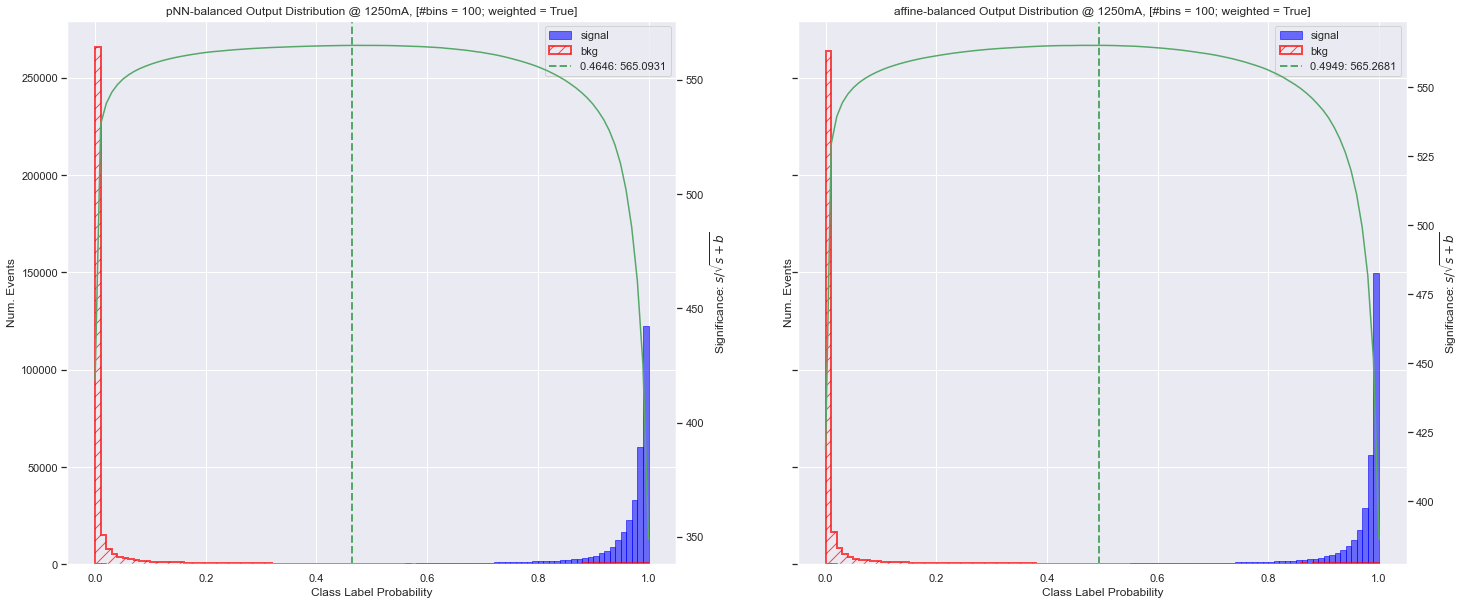

=== 1500 mA ===


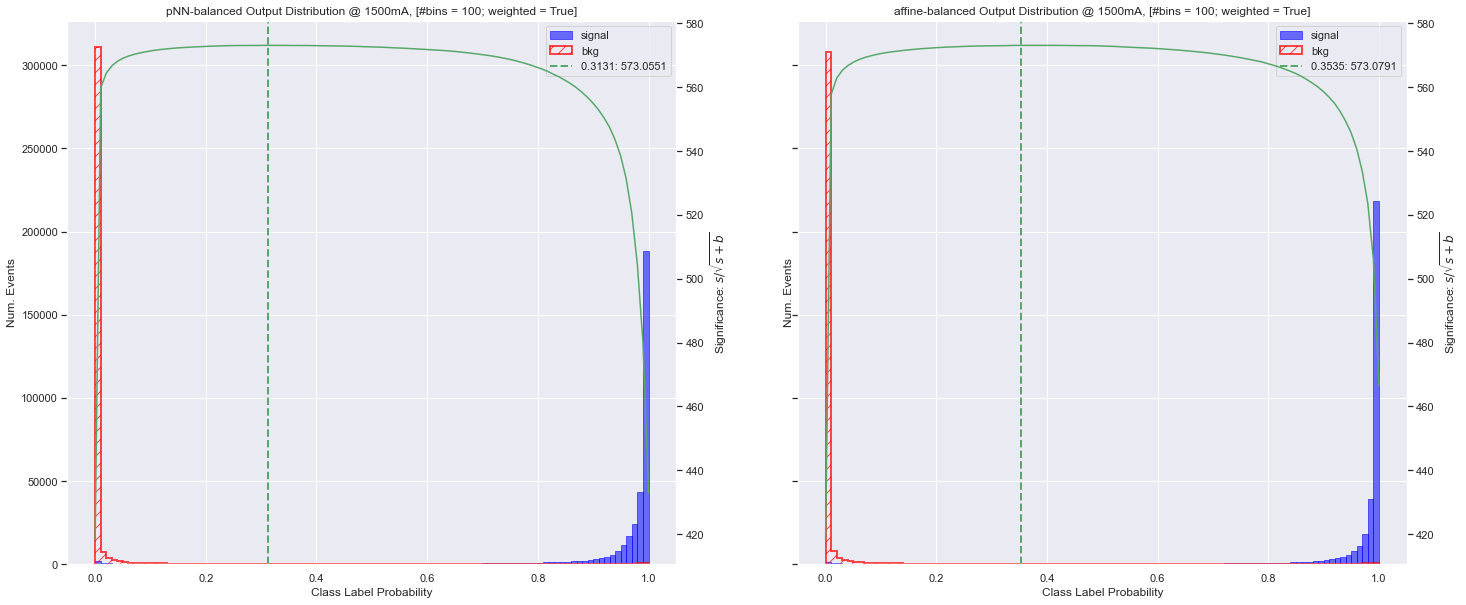

In [18]:
models = {'pNN-balanced': balanced, 'affine-balanced': affine_bal}

for mass in test.unique_signal_mass:
    print(f'=== {int(mass)} mA ===')
    axes = utils.get_plot_axes(rows=1, cols=2, sharey=True)
    
    for ax, (name, pnn) in zip(axes, models.items()):
        hep.plot.significance(pnn, test, mass=mass, bins=100, ax=ax, name=name, 
                              show=False, ratio=False)
    plt.show()
    free_mem()

ROC/PR Curves:

In [16]:
models_cuts = {}

for k, pnn in models.items():
    _, cuts = hep.plot.get_ams_and_cut(pnn, test, bins=100)
    models_cuts[k] = (pnn, cuts)

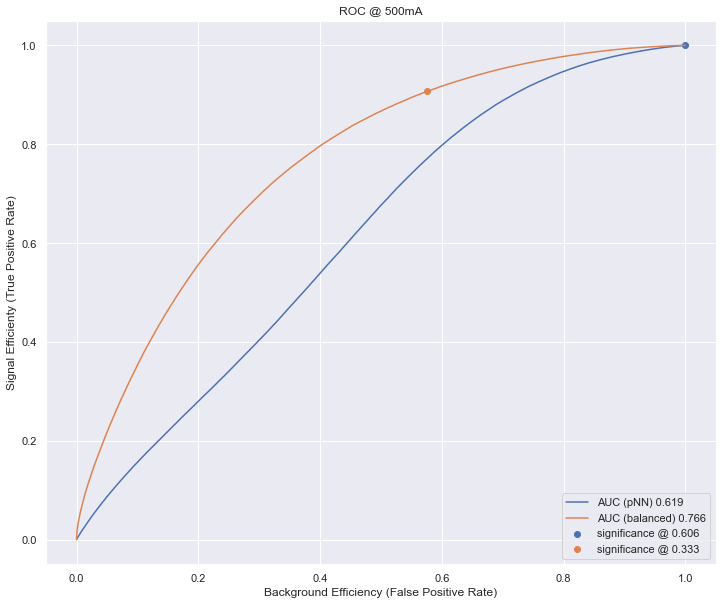

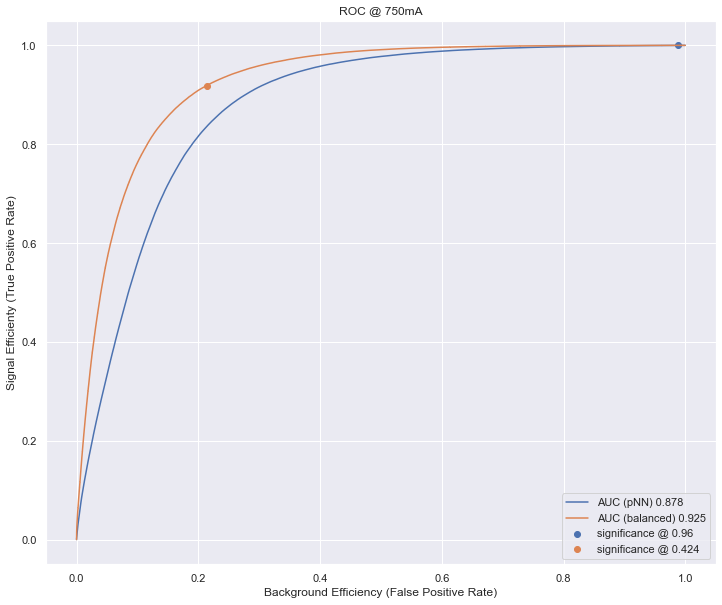

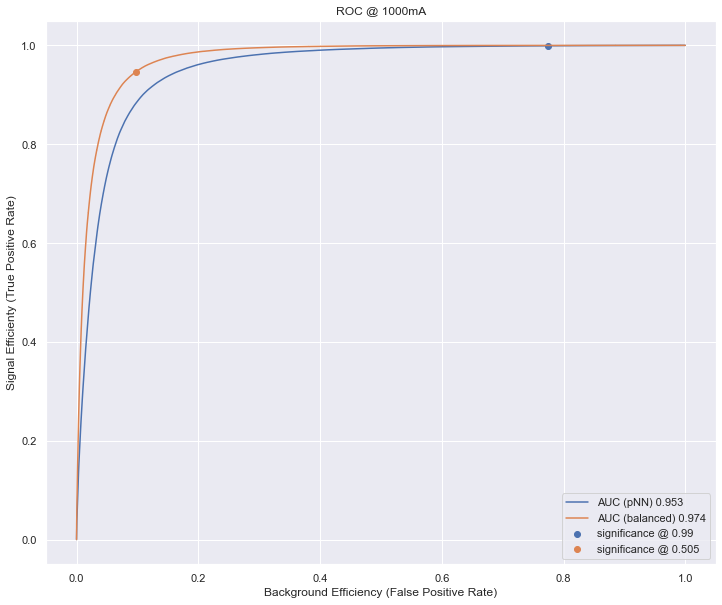

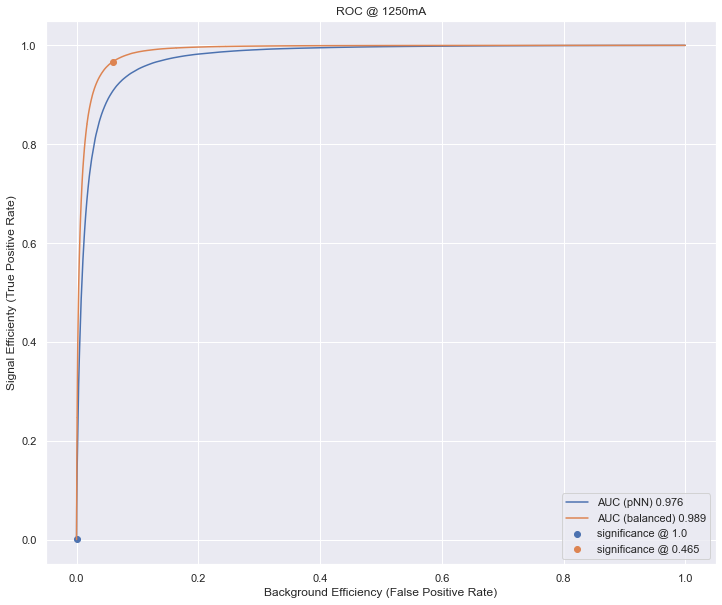

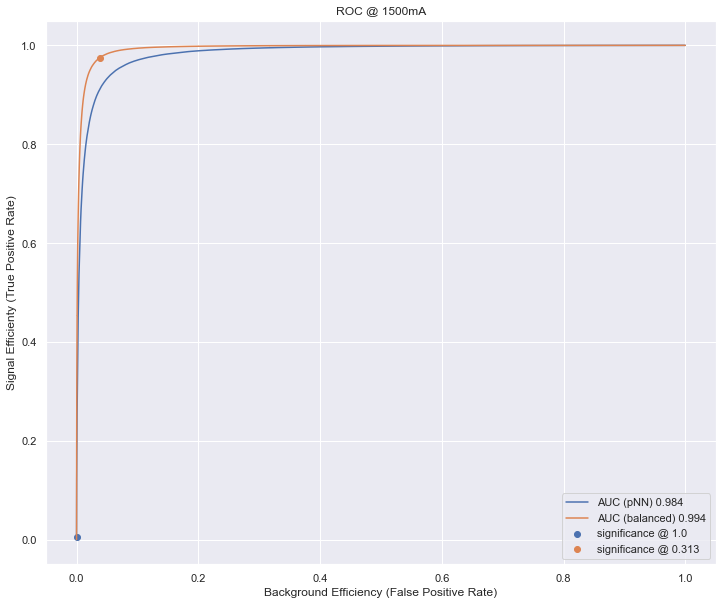

In [17]:
# ROC
for i, mass in enumerate(test.unique_signal_mass):
    hep.plot.compare_roc(test, {k: (pnn, cuts[i]) for k, (pnn, cuts) in models_cuts.items()}, 
                         mass=mass)
    free_mem()


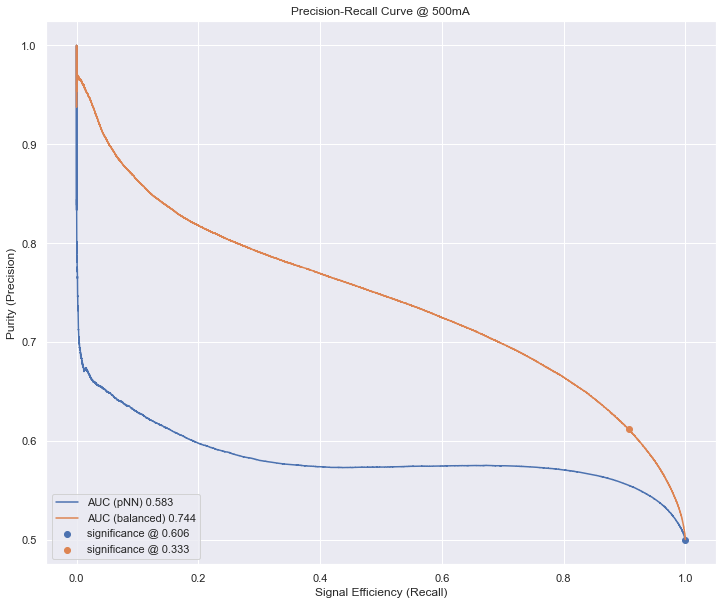

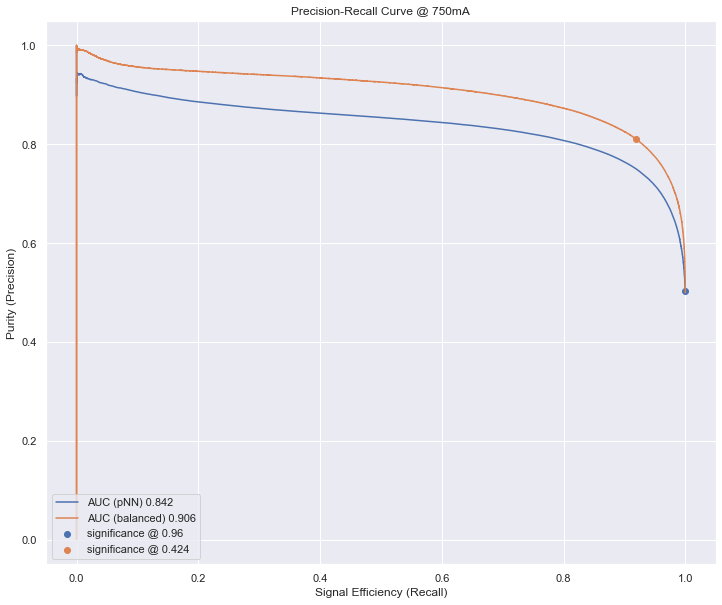

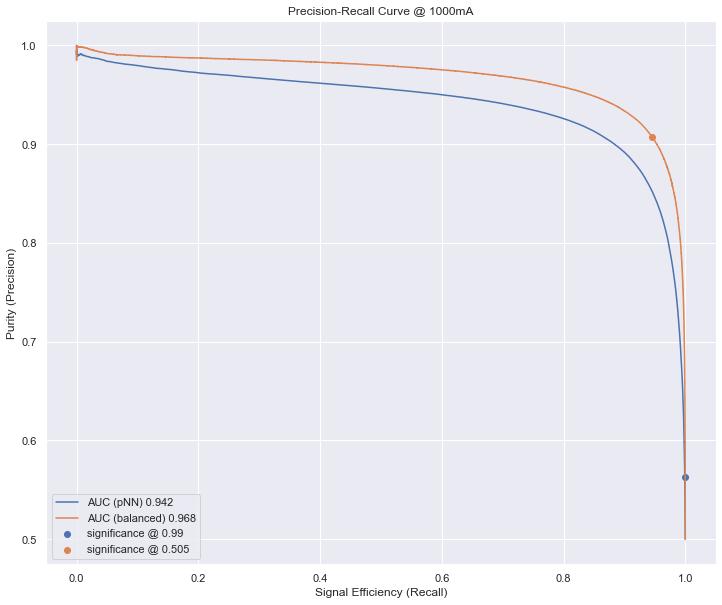

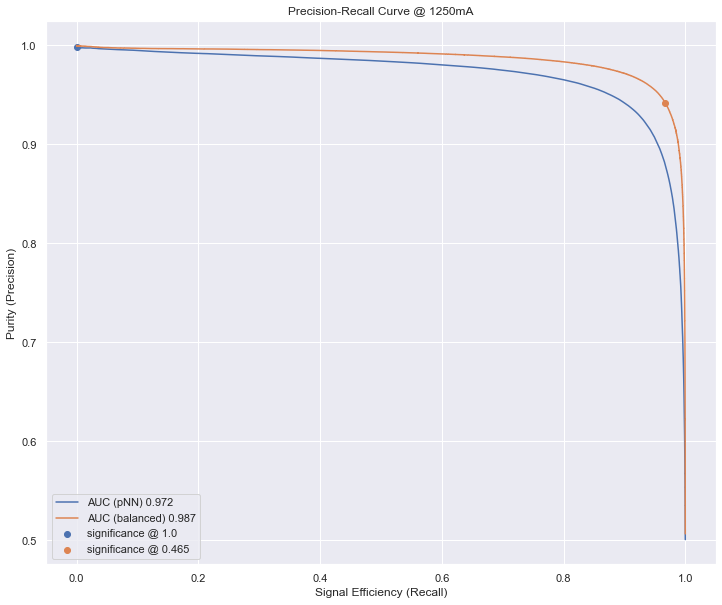

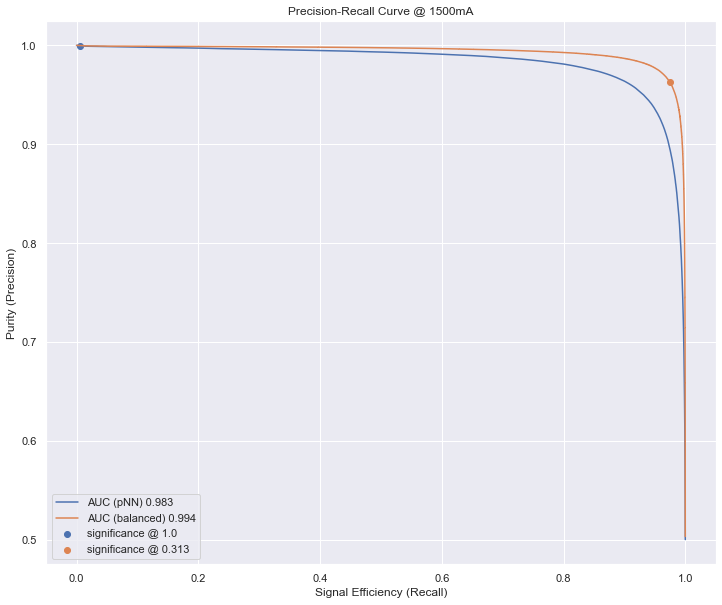

In [18]:
# PR
for i, mass in enumerate(test.unique_signal_mass):
    hep.plot.compare_pr(test, {k: (pnn, cuts[i]) for k, (pnn, cuts) in models_cuts.items()}, 
                        mass=mass)
    free_mem()
